# Baseline AQA Model


Draft implementation of the following model. 

Will use distillBERT to embed all content as if they were single sentences. 

Each of the three types of sentence (context, content, question) will be embedded in a smaller latent space, before being concatenated to be passed to a prediction layer. 

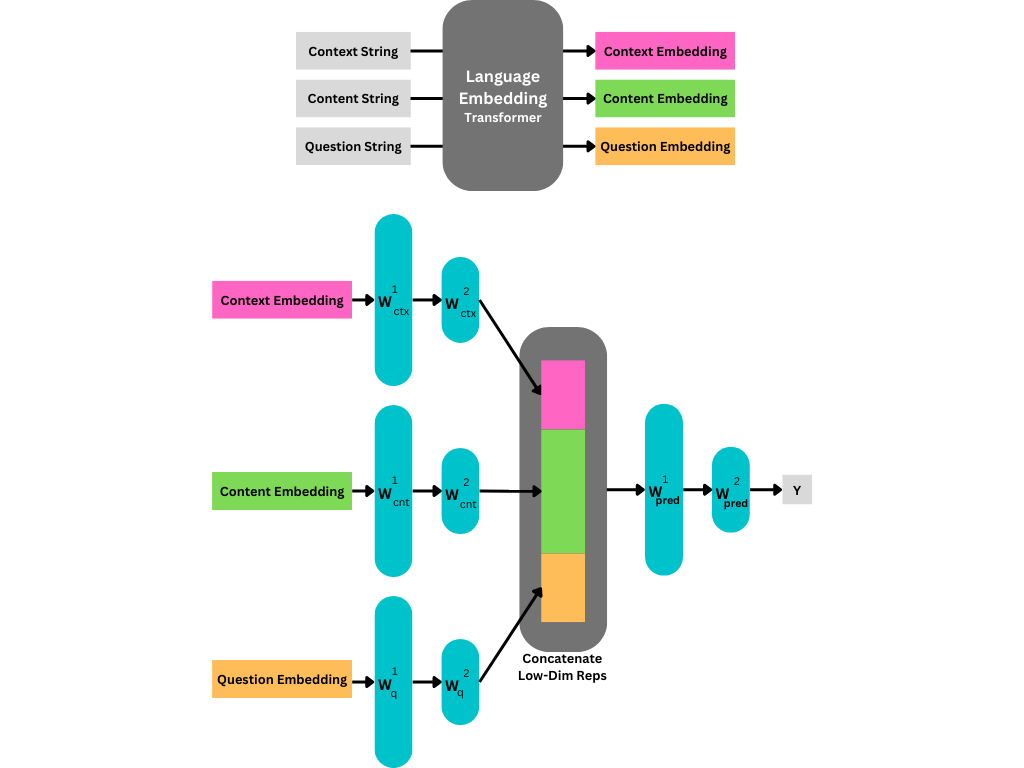

# Setup

## Imports

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import warnings
warnings.filterwarnings('ignore')

from tqdm.notebook import tqdm

## Constants

In [2]:
GCS_APP_ID = "aqa-research"
GCS_BUCKET = "dabi-aqa-data-00"

FN_QUESTIONS = "questions_01.csv"
FN_CONTEXTS  = "contexts_01.csv"
FN_CONTENT_ANSWERS   = "content_answers_01.csv"

MAX_SEQ_LEN = 128

## GCS Auth - Input Needed

In [3]:
!gcloud auth login --launch-browser

Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fsdk.cloud.google.com%2Fauthcode.html&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=j3dE8sKYNQYjnXQ2T0bf3c9QwPBHlV&prompt=consent&access_type=offline&code_challenge=0vBHmvqXl6iZHxkRzjcTntFKn1DD0IDJvRqgyykSfLE&code_challenge_method=S256

Enter authorization code: 4/0AfgeXvvhUxY15pJXFb42c1TMWyt1t3dr7xpY-lSKNDtpMRp_-A-Onej8u2mG8PI-VgvC6A

You are now logged in as [willpowe@gmail.com].
Your current project is [aqa-research].  You can change this setting by running:
  $ gcloud config set project PROJECT_I

In [4]:
!gcloud config set project {GCS_APP_ID}

Updated property [core/project].


In [5]:
def download_file_from_gcs(src_fn, dest_fn):
  dest = f"/content/{dest_fn}"
  dl_command = f"gsutil -m cp gs://{GCS_BUCKET}/{src_fn} {dest}"
  os.system(dl_command)

def upload_file_to_gcs(src_fn, dest_fn):
  dest_url = "{}/{}".format(GCS_BUCKET, dest_fn)
  ul_command = "gsutil -m cp {} gs://{}".format(src_fn, dest_url)
  os.system(ul_command)

## Raw Data

In [6]:
download_file_from_gcs(FN_QUESTIONS, FN_QUESTIONS)
download_file_from_gcs(FN_CONTEXTS, FN_CONTEXTS)
download_file_from_gcs(FN_CONTENT_ANSWERS, FN_CONTENT_ANSWERS)

## BERT Setup

In [7]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
import transformers as ppb

# Data

## Embedding Raw Data

In [9]:
# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

## Want BERT instead of distilBERT? Uncomment the following line:
#model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights, truncate=True,)
model = model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [10]:
questions = pd.read_csv(FN_QUESTIONS)
contexts  = pd.read_csv(FN_CONTEXTS)
content_answers = pd.read_csv(FN_CONTENT_ANSWERS)

In [11]:
def prepare_padded_sequences(df_in, text_col):
  # Tokenize
  df_in['tokens'] = df_in[text_col].apply(lambda x: tokenizer.encode(x,
                                                                     max_length=MAX_SEQ_LEN,
                                                                     add_special_tokens=True))
  df_in['num_tokens'] = df_in['tokens'].apply(lambda x: len(x))
  max_len = df_in['num_tokens'].max()
  return np.array([i + [0]*(max_len-len(i)) for i in df_in['tokens'].values])

# A side effect of this is all the DF's passed in will have a 'tokens' column 
# added to them. 
padded_questions = torch.tensor(prepare_padded_sequences(questions, 'question_text'))
padded_contexts  = torch.tensor(prepare_padded_sequences(contexts, 'context_text'))
padded_content   = torch.tensor(prepare_padded_sequences(content_answers, 'content_text'))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


We need masks to properly train/embed the sentences. 

In [12]:
mask_questions =  torch.tensor(np.where(padded_questions != 0, 1, 0))
mask_contexts  =  torch.tensor(np.where(padded_contexts != 0, 1, 0))
mask_content   =  torch.tensor(np.where(padded_content != 0, 1, 0))

Now we can process the padded content to obtain token level embeddings for each comment. 

In [13]:
with torch.no_grad():
    lhs_questions = model(padded_questions, attention_mask=mask_questions)
    lhs_contexts  = model(padded_contexts, attention_mask=mask_contexts)
    lhs_content   = model(padded_content, attention_mask=mask_content)

The following truncates all but the first embedding (which corresponds to the CLS token, representing the full sentence embedding).

In [14]:
emb_questions = lhs_questions[0][:,0,:]
emb_contexts  = lhs_contexts[0][:,0,:]
emb_comments  = lhs_content[0][:,0,:]

## Creating Example Tuples

Once here, we can use the original dataframe for the content answers to create the actual input tuples; (emb_ctx, emb_question, emb_content, answer)

In [15]:
questions['embedding'] = list(emb_questions)
contexts['embedding']  = list(emb_contexts)
content_answers['content-embedding'] = list(emb_comments)

In [16]:
# Making some maps so we can quickly build tuples. 
map_q_emb = dict()
map_ctx_emb = dict()


def build_q_map(row):
  global map_q_emb
  map_q_emb[row['question_id']] = row['embedding']

def build_ctx_map(row):
  global map_ctx_emb
  map_ctx_emb[row['context_id']] = row['embedding']


questions.apply(build_q_map, axis=1)
contexts.apply(build_ctx_map, axis=1)

0    None
1    None
2    None
3    None
4    None
5    None
dtype: object

Now we have all we need to make tuples. 

In [17]:
example_tuples = []

def make_tuple(row):
  global example_tuples
  exp = [map_ctx_emb[row['context_id']],
         map_q_emb[row['question_id']],
         row['content-embedding'],
         row['answer']]
  example_tuples.append(exp)

content_answers.apply(make_tuple, axis=1)
print(len(example_tuples))

4000


## Creating Train/Test Batches

In [18]:
TEST_FRAC = 0.1
NUM_TRAIN = int((1-TEST_FRAC)*len(example_tuples))

train_tuples = example_tuples[:NUM_TRAIN]
test_tuples  = example_tuples[NUM_TRAIN:]

In [19]:
BATCH_SIZE = 64
training_batches = [train_tuples[i:i+BATCH_SIZE] for i in range(int(NUM_TRAIN/BATCH_SIZE))]

# Stack the tensors inside each batch, so its still 1 tuple per batch
training_stacked = []
for batch in training_batches:
  q_tensors   = [i[0] for i in batch]
  ctx_tensors = [i[1] for i in batch]
  cnt_tensors = [i[2] for i in batch]
  y_tensor    = torch.tensor([i[3] for i in batch], dtype=torch.float)
  training_stacked.append([torch.stack(q_tensors),
                           torch.stack(ctx_tensors),
                           torch.stack(cnt_tensors),
                           torch.reshape(y_tensor, (-1, 1))])

q_test   = torch.stack([i[0] for i in test_tuples])
ctx_test = torch.stack([i[1] for i in test_tuples])
cnt_test = torch.stack([i[2] for i in test_tuples])

y_test   = torch.tensor([[i[3] for i in test_tuples]], dtype=torch.float)
y_test   = torch.reshape(y_test, (-1, 1))
test_batch = [q_test, ctx_test, cnt_test]

# Model Implementation

In [20]:
import torch.nn.functional as F
from torch.nn import Module, RNN, Linear, BCELoss, LogSoftmax, BatchNorm1d

NUM_BERT_FEATURES = 768

HL_QUESTION = 8
HL_CONTEXTS = 8
HL_CONTENT  = 16
HL_PRED = 8

class AQAM(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # 3 MLP Stacks
        self.q_linear1 = Linear(NUM_BERT_FEATURES, HL_QUESTION)
        self.ctx_linear1 = Linear(NUM_BERT_FEATURES, HL_CONTEXTS)
        self.content_linear1 = Linear(NUM_BERT_FEATURES, HL_CONTENT)
        
        # Prediction Layers
        self.pred_linear1 = Linear(HL_QUESTION+HL_CONTEXTS+HL_CONTENT, HL_PRED)
        self.pred_linear2 = Linear(HL_PRED, 1)

        # Batch Norms
        self.bn_q    = BatchNorm1d(HL_QUESTION)
        self.bn_ctx  = BatchNorm1d(HL_CONTEXTS)
        self.bn_cnt  = BatchNorm1d(HL_CONTENT) 
        self.bn_cat  = BatchNorm1d(HL_PRED) 

    def forward(self, data):
        emb_q, emb_ctx, emb_cnt = data[0], data[1], data[2]

        # The 3 Heads - Question, Context, Content spaces.
        ls_q   = self.q_linear1(emb_q)
        ls_q   = F.relu(ls_q)


        ls_ctx = self.ctx_linear1(emb_ctx)
        ls_ctx = F.relu(ls_ctx)
        
        ls_cnt = self.content_linear1(emb_cnt)
        ls_cnt = F.relu(ls_cnt)

        # Note - Needed to make this work 1-dimension 'up', to make it work
        #        with batches. basically needed to skip the 0th batch dim.
        ls_cat = torch.cat((self.bn_q(ls_q), 
                            self.bn_ctx(ls_ctx), 
                            self.bn_cnt(ls_cnt)), 
                           dim=1)
        
        # Prediction Layers
        ls_cat = self.pred_linear1(ls_cat)
        ls_cat = self.bn_cat(F.relu(ls_cat))
        pred   = self.pred_linear2(ls_cat)
        
        return pred

# Training

In [21]:
from torch.optim import SGD

In [22]:
def binary_acc(y_pred, y_test):
  # Where we handle the sigmoid for the BC
  y_pred_tag = torch.round(torch.sigmoid(y_pred))
  correct_results_sum = (y_pred_tag == y_test).sum().float()
  acc = correct_results_sum/float(y_test.shape[0])
  return acc

In [29]:
model = AQAM()
optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = torch.nn.BCEWithLogitsLoss()

EPOCHS = 40

full_batch_train_accs = []
train_accs = []
test_accs = []
for epoch in tqdm(range(EPOCHS), unit="epoch"):
  model.train()
  optimizer.zero_grad()
  
  batch_accs = []
  for batch in training_stacked:
    out = model(batch)
    labels = batch[3]
    loss = criterion(out, labels)
    loss.backward()
    optimizer.step()
    batch_accs.append(binary_acc(out, labels))
  full_batch_train_accs.extend(batch_accs)
  train_accs.append(sum(batch_accs)/float(len(batch_accs)))

  model.eval()
  test_out = model(test_batch)
  test_accs.append(binary_acc(test_out, y_test))

  0%|          | 0/40 [00:00<?, ?epoch/s]

# Results

In [43]:
print(len(train_tuples))
print(len(test_tuples))

3600
400


In [33]:
prinlen(full_batch_train_accs))

2240


In [36]:
scaling = float(EPOCHS)/float(len(full_batch_train_accs))
fbta_xs = [i*scaling for i in range(len(full_batch_train_accs))]

0.017857142857142856


In [25]:
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib inline

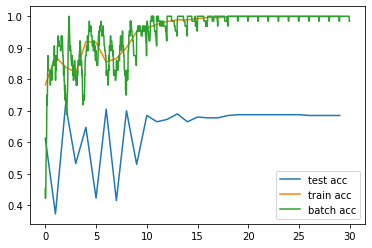

In [41]:
CUTOFF_EPOCH = 30
CUTOFF_FBTA = int(CUTOFF_EPOCH/scaling)

plt.plot(test_accs[:CUTOFF_EPOCH],  
         label="test acc")

plt.plot(train_accs[:CUTOFF_EPOCH], 
         label="train acc")

plt.plot(fbta_xs[:CUTOFF_FBTA], 
         full_batch_train_accs[:CUTOFF_FBTA], 
         label="batch acc")

plt.legend(loc="lower right")
plt.show()